In [ ]:
import json
import os
from google.colab import drive

# --- 1. Mount Google Drive ---
drive.mount('/content/drive')

# --- 2. Install Libraries ---
!pip install transformers rouge-score tqdm

# --- 3. Define Helper Function to Load Data ---
def load_data(path):
    """Loads a .jsonl file."""
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# --- 4. Set Dataset Path and Load Files ---
# IMPORTANT: Change this path to where your wikisql data is stored
base_path = '/content/drive/MyDrive/wikisql/archive/'

# Load the main data splits
try:
    train_data = load_data(os.path.join(base_path, 'train.jsonl'))
    dev_data = load_data(os.path.join(base_path, 'dev.jsonl'))
    test_data = load_data(os.path.join(base_path, 'test.jsonl'))

    # Load the table files
    train_tables = load_data(os.path.join(base_path, 'train.tables.jsonl'))
    test_tables = load_data(os.path.join(base_path, 'test.tables.jsonl'))

    # --- 5. Verify Loading ---
    print("--- Dataset Loading Successful ---")
    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of development samples: {len(dev_data)}")
    print(f"Number of test samples: {len(test_data)}")
    print(f"Number of training tables: {len(train_tables)}")
    print(f"Number of test tables: {len(test_tables)}")

except FileNotFoundError as e:
    print(f"Error: Could not find a file. Please check your base_path.")
    print(f"Details: {e}")

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a3877fcb0a29b6adf01227514f18e1d1d3e9ea57542a61f78e2636a731c411df
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
--- Dataset Loading Successful ---
Number of training samples: 56355
Number of development samples: 8421
Number of test samples: 15878
Number of training tables: 18585
Number of test tables: 5230


In [ ]:
import random
import re

# --- 1. Helper Function to Convert Sketch to SQL (No changes) ---
def sketch_to_sql(sql_json, table_header):
    agg_map = ['NONE', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']
    op_map = ['=', '>', '<', 'OP']
    sel_col_name = f'"{table_header[sql_json["sel"]]}"'
    if agg_map[sql_json["agg"]] == 'NONE':
        select_clause = f"SELECT {sel_col_name}"
    else:
        select_clause = f"SELECT {agg_map[sql_json['agg']]}({sel_col_name})"
    where_clauses = []
    for col_idx, op_idx, val in sql_json['conds']:
        col_name = f'"{table_header[col_idx]}"'
        op = op_map[op_idx]
        if isinstance(val, (int, float)):
            where_clauses.append(f"{col_name} {op} {val}")
        else:
            val_escaped = str(val).replace("'", "''")
            where_clauses.append(f"{col_name} {op} '{val_escaped}'")
    if where_clauses:
        where_clause = " WHERE " + " AND ".join(where_clauses)
    else:
        where_clause = ""
    return f"{select_clause} FROM table{where_clause}"

In [ ]:
def random_entity_shuffling(question, sql_json, table_header, debug=False):
    """
    Identifies entities from SELECT and WHERE clauses and shuffles them in the question.
    """
    entities_to_find = set()

    sel_col_name = table_header[sql_json['sel']]
    for part in sel_col_name.split():
        entities_to_find.add(part.lower())

    for col_idx, _, val in sql_json['conds']:
        col_name = table_header[col_idx]
        for part in col_name.split():
            entities_to_find.add(part.lower())
        val_str = str(val)
        for part in val_str.split():
            entities_to_find.add(part.lower())

    if debug:
        print(f"DEBUG: Entities to find: {entities_to_find}")

    question_parts = re.findall(r"[\w']+|[.,!?;]", question)

    found_entities = []
    for i, part in enumerate(question_parts):
        if part.lower() in entities_to_find:
            found_entities.append({'word': part, 'index': i})

    if debug:
        print(f"DEBUG: Found entities in question: {found_entities}")

    if len(found_entities) > 1:
        words_to_shuffle = [e['word'] for e in found_entities]
        if debug: print(f"DEBUG: Words to shuffle (before): {words_to_shuffle}")

        # We create a shuffled copy to ensure it's different for debugging
        shuffled_words = words_to_shuffle[:]
        while shuffled_words == words_to_shuffle:
            random.shuffle(shuffled_words)

        if debug: print(f"DEBUG: Words to shuffle (after):  {shuffled_words}")

        new_question_parts = question_parts[:]
        for i, entity in enumerate(found_entities):
            original_index = entity['index']
            new_question_parts[original_index] = shuffled_words[i]
            if debug: print(f"DEBUG: Step {i}: Swapped '{entity['word']}' with '{shuffled_words[i]}'. New question parts: {' '.join(new_question_parts)}")

        return " ".join(new_question_parts)

    return question

In [ ]:
# --- 3. Main Augmentation Wrapper (No changes) ---
def augment_sample(sample, table, augmentation_probability=0.5, debug=False):
    original_question = sample['question']
    if random.random() < augmentation_probability:
        augmented_question = random_entity_shuffling(original_question, sample['sql'], table['header'], debug=debug)
        was_changed = (augmented_question != original_question)
        return augmented_question, was_changed
    return original_question, False

In [ ]:
# --- 4. Example Usage (for verification) ---
table_map = {t['id']: t for t in train_tables}
sample_to_test = train_data[0]
corresponding_table = table_map[sample_to_test['table_id']]

print("--- Testing Final Augmentation ---")
print(f"Original Question: {sample_to_test['question']}")

augmented_q, was_changed = augment_sample(sample_to_test, corresponding_table, augmentation_probability=1.0, debug=True)

print(f"\nAugmented Question: {augmented_q}")
print(f"Was the question changed? {was_changed}")

print("\n--- Testing SQL Conversion ---")
print(f"Generated SQL Query: {sketch_to_sql(sample_to_test['sql'], corresponding_table['header'])}")

--- Testing Final Augmentation ---
Original Question: Tell me what the notes are for South Australia 
DEBUG: Entities to find: {'current', 'south', 'notes', 'australia', 'slogan'}
DEBUG: Found entities in question: [{'word': 'notes', 'index': 4}, {'word': 'South', 'index': 7}, {'word': 'Australia', 'index': 8}]
DEBUG: Words to shuffle (before): ['notes', 'South', 'Australia']
DEBUG: Words to shuffle (after):  ['South', 'Australia', 'notes']
DEBUG: Step 0: Swapped 'notes' with 'South'. New question parts: Tell me what the South are for South Australia
DEBUG: Step 1: Swapped 'South' with 'Australia'. New question parts: Tell me what the South are for Australia Australia
DEBUG: Step 2: Swapped 'Australia' with 'notes'. New question parts: Tell me what the South are for Australia notes

Augmented Question: Tell me what the South are for Australia notes
Was the question changed? True

--- Testing SQL Conversion ---
Generated SQL Query: SELECT "Notes" FROM table WHERE "Current slogan" = 'SOU

In [ ]:
# This dictionary maps table_id to its corresponding table for quick access
# Make sure this was created successfully in a previous cell
table_map = {t['id']: t for t in train_tables}

print("--- Starting Debug Process ---")

# Isolate the very first training sample
first_sample = train_data[0]
print(f"Testing with the first sample, which has table_id: '{first_sample['table_id']}'")

# --- Step 1: Check for KeyError ---
try:
    # Try to find the corresponding table in our map
    table = table_map[first_sample['table_id']]
    print("✅ SUCCESS: Table lookup was successful. The KeyError is NOT the issue.")

    # --- Step 2: Test the augmentation function on its own ---
    print("\nNow testing the augmentation function...")
    augmented_q, was_changed = augment_sample(first_sample, table, debug=True)
    print("✅ SUCCESS: Augmentation function ran without getting stuck.")
    print(f"Result -> Augmented Question: {augmented_q}")

except KeyError:
    print("\n❌ ERROR: A KeyError occurred!")
    print("This means the table_id from the first training sample was not found in your table data.")
    print("Please verify that your 'train.tables.jsonl' file loaded correctly in Block 1.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

--- Starting Debug Process ---
Testing with the first sample, which has table_id: '1-1000181-1'
✅ SUCCESS: Table lookup was successful. The KeyError is NOT the issue.

Now testing the augmentation function...
✅ SUCCESS: Augmentation function ran without getting stuck.
Result -> Augmented Question: Tell me what the notes are for South Australia 


In [ ]:
from tqdm import tqdm

# These lists will store our final training data
input_texts = []
target_texts = []

num_samples = len(train_data)
print(f"--- Starting BAREBONES data preprocessing for {num_samples} samples ---")
print("NOTE: Data augmentation is temporarily disabled to force the loop to run.")

# Loop through each sample in the training data
for sample in tqdm(train_data):
    try:
        # Memory-safe table lookup
        table = next(t for t in train_tables if t['id'] == sample['table_id'])

        # --- AUGMENTATION IS SKIPPED ---
        # We use the original question directly
        original_question = sample['question']

        # Format the input text for the T5 model
        columns_str = ", ".join(table['header'])
        input_text = f"Generate SQL: {original_question} | Columns: {columns_str}"

        # Generate the target SQL query string
        target_text = sketch_to_sql(sample['sql'], table['header'])

        # Add the processed texts to our lists
        input_texts.append(input_text)
        target_texts.append(target_text)
    except StopIteration:
        print(f"Warning: Could not find table for sample with table_id: {sample.get('table_id', 'N/A')}. Skipping.")
        continue

print("\n--- Preprocessing Complete ---")
print(f"Total processed samples: {len(input_texts)}")

# --- Verification Step ---
print("\n--- Verifying a few examples ---")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"  Input Text:  {input_texts[i]}")
    print(f"  Target SQL: {target_texts[i]}")

--- Starting BAREBONES data preprocessing for 56355 samples ---
NOTE: Data augmentation is temporarily disabled to force the loop to run.


100%|██████████| 56355/56355 [01:10<00:00, 804.65it/s]


--- Preprocessing Complete ---
Total processed samples: 56355

--- Verifying a few examples ---

Example 1:
  Input Text:  Generate SQL: Tell me what the notes are for South Australia  | Columns: State/territory, Text/background colour, Format, Current slogan, Current series, Notes
  Target SQL: SELECT "Notes" FROM table WHERE "Current slogan" = 'SOUTH AUSTRALIA'

Example 2:
  Input Text:  Generate SQL: What is the current series where the new series began in June 2011? | Columns: State/territory, Text/background colour, Format, Current slogan, Current series, Notes
  Target SQL: SELECT "Current series" FROM table WHERE "Notes" = 'New series began in June 2011'

Example 3:
  Input Text:  Generate SQL: What is the format for South Australia? | Columns: State/territory, Text/background colour, Format, Current slogan, Current series, Notes
  Target SQL: SELECT "Format" FROM table WHERE "State/territory" = 'South Australia'


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Define the name of the pre-trained model we want to use
model_name = "t5-base"

print(f"--- Initializing model and tokenizer for '{model_name}' ---")

# Load the tokenizer
# The tokenizer converts our text into a format the model can understand.
tokenizer = T5Tokenizer.from_pretrained(model_name)
print("✅ Tokenizer loaded successfully.")

# Load the model
# T5ForConditionalGeneration is designed for sequence-to-sequence tasks like ours.
model = T5ForConditionalGeneration.from_pretrained(model_name)
print(f"✅ Model '{model_name}' loaded successfully.")

# You can optionally check the model's configuration
# print("\nModel Configuration:")
# print(model.config)

--- Initializing model and tokenizer for 't5-base' ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


✅ Tokenizer loaded successfully.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Model 't5-base' loaded successfully.


In [ ]:
from torch.utils.data import Dataset
import torch

print("--- Tokenizing data and creating PyTorch Dataset ---")

# Tokenize the input texts (questions + schema)
# padding=True ensures all sequences in a batch have the same length.
# truncation=True cuts off sequences longer than the model can handle.
inputs_tokenized = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    return_tensors="pt" # Return PyTorch tensors
)
print("✅ Input texts tokenized.")

# Tokenize the target texts (the SQL queries)
targets_tokenized = tokenizer(
    target_texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)
print("✅ Target texts (SQL queries) tokenized.")


# Define a custom PyTorch Dataset
class Text2SQLDataset(Dataset):
    def __init__(self, inputs, targets):
        self.input_ids = inputs["input_ids"]
        self.attention_mask = inputs["attention_mask"]
        # The 'labels' are the target token ids for the model to predict
        self.labels = targets["input_ids"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

# Create an instance of our dataset
train_dataset = Text2SQLDataset(inputs_tokenized, targets_tokenized)

print(f"\n✅ Dataset created successfully.")
print(f"Number of samples in the dataset: {len(train_dataset)}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--- Tokenizing data and creating PyTorch Dataset ---
✅ Input texts tokenized.
✅ Target texts (SQL queries) tokenized.

✅ Dataset created successfully.
Number of samples in the dataset: 56355


In [ ]:
from transformers import Trainer, TrainingArguments
from transformers.cache_utils import EncoderDecoderCache

# --- 1. Define Training Arguments ---
# These arguments control the entire fine-tuning process.
training_args = TrainingArguments(
    # Directory where the model checkpoints will be saved
    output_dir="/content/t5_text2sql_model",

    # --- Key Hyperparameters ---
    num_train_epochs=1,  # We will train for one full epoch.
    per_device_train_batch_size=8, # Number of samples processed in one go. 8 is good for a T4 GPU.
    learning_rate=5e-5,  # The speed at which the model learns. 5e-5 is a good default.

    # --- Performance and Logging ---
    fp16=True,  # Use mixed-precision training for a significant speed-up on T4 GPUs.
    logging_steps=500,  # Print the training loss every 500 steps.
    save_strategy="no", # We will save manually at the end, so no need to save during training.
    report_to="none", # Disables integration with services like Weights & Biases.
)

# --- 2. Initialize the Trainer ---
# The Trainer class handles the entire training loop for us.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # We don't have an evaluation set for this example, but it could be added here.
    # eval_dataset=...
)

print("--- Starting Model Training ---")
print(f"This will take approximately 2-3 hours to complete for 1 epoch.")

# --- 3. Start Training ---
# This command begins the fine-tuning process.
trainer.train()

print("\n--- Training Complete! ---")

--- Starting Model Training ---
This will take approximately 2-3 hours to complete for 1 epoch.


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,0.389700
1000,0.036500
1500,0.030500
2000,0.027500
2500,0.024900
3000,0.023000
3500,0.024600
4000,0.022400
4500,0.022300
5000,0.020100



--- Training Complete! ---


In [ ]:
# Define the directory where you want to save the final model
output_dir = "/content/t5-text2sql-final-model"

print(f"--- Saving the fine-tuned model to {output_dir} ---")

# Save the model's learned weights and configuration
model.save_pretrained(output_dir)

# Save the tokenizer so we can use it for inference later
tokenizer.save_pretrained(output_dir)

print(f"\n✅ Model and tokenizer saved successfully.")
print("You can see the new folder in the file browser on the left side of your Colab window.")

--- Saving the fine-tuned model to /content/t5-text2sql-final-model ---

✅ Model and tokenizer saved successfully.
You can see the new folder in the file browser on the left side of your Colab window.


In [ ]:
import sqlite3
from tqdm import tqdm
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# --- Configuration ---
# Set to True for a quick run on 2000 samples, or False for the full official run.
QUICK_TEST = False

# --- 1. Load our fine-tuned model and tokenizer ---
model_dir = "/content/t5-text2sql-final-model"
tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir).to('cuda')
print("✅ Fine-tuned model and tokenizer loaded.")

# Create the map of test tables needed for evaluation
test_table_map = {t['id']: t for t in test_tables}

# --- 2. Define the SQL Execution Function ---
def execute_sql(sql_query, table_data):
    """Creates an in-memory SQLite DB, executes the query, and returns the result."""
    try:
        conn = sqlite3.connect(':memory:')
        cursor = conn.cursor()
        headers = [f'"{h}"' for h in table_data['header']]
        cursor.execute(f"CREATE TABLE 'table' ({','.join(headers)});")
        for row in table_data['rows']:
            str_row = tuple(map(str, row))
            cursor.execute(f"INSERT INTO 'table' VALUES ({','.join(['?']*len(str_row))})", str_row)
        result = cursor.execute(sql_query).fetchall()
        conn.close()
        return result
    except Exception as e:
        return f"Error: {e}"

# --- 3. Prepare Data Subset if needed ---
if QUICK_TEST:
    test_data_to_run = test_data[:2000]
    print("\n--- RUNNING IN QUICK TEST MODE ON 2000 SAMPLES ---")
else:
    test_data_to_run = test_data
    print("\n--- RUNNING FULL EVALUATION ON ALL SAMPLES ---")

# --- 4. BATCHED Evaluation Loop ---
lf_correct = 0
ex_correct = 0
num_samples = len(test_data_to_run)
batch_size = 32

for i in tqdm(range(0, num_samples, batch_size), desc="Evaluating Batches"):
    batch = test_data_to_run[i:i + batch_size]

    input_prompts = []
    for sample in batch:
        table = test_table_map.get(sample['table_id'])
        if not table: continue
        columns_str = ", ".join(table['header'])
        input_prompts.append(f"Generate SQL: {sample['question']} | Columns: {columns_str}")

    inputs = tokenizer(input_prompts, return_tensors="pt", padding=True, truncation=True).to('cuda')

    model_outputs = model.generate(
        **inputs,
        max_length=128,
        num_beams=5,
        num_return_sequences=5,
        early_stopping=True
    )

    for j, sample in enumerate(batch):
        sample_outputs = model_outputs[j*5:(j+1)*5]

        # --- THIS IS THE CORRECTED LINE ---
        table = test_table_map.get(sample['table_id']) # Use 'table_id' instead of 'id'
        if not table: continue

        true_sql = sketch_to_sql(sample['sql'], table['header'])
        true_result = execute_sql(true_sql, table)

        best_sql = None
        predicted_result = None
        for beam_output in sample_outputs:
            decoded_sql = tokenizer.decode(beam_output, skip_special_tokens=True)
            result = execute_sql(decoded_sql, table)
            if not isinstance(result, str):
                best_sql = decoded_sql
                predicted_result = result
                break

        if best_sql is None:
            best_sql = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
            predicted_result = execute_sql(best_sql, table)

        if best_sql.strip().lower() == true_sql.strip().lower():
            lf_correct += 1
        if predicted_result == true_result:
            ex_correct += 1

# --- 5. Calculate and Print Final Scores ---
lf_accuracy = (lf_correct / num_samples) * 100
ex_accuracy = (ex_correct / num_samples) * 100

print("\n--- Evaluation Complete! ---")
print(f"Logical Form (LF) Accuracy: {lf_accuracy:.2f}%")
print(f"Execution (EX) Accuracy:    {ex_accuracy:.2f}%")


✅ Fine-tuned model and tokenizer loaded.

--- RUNNING FULL EVALUATION ON ALL SAMPLES ---


Evaluating Batches: 100%|██████████| 497/497 [18:49<00:00,  2.27s/it]


--- Evaluation Complete! ---
Logical Form (LF) Accuracy: 59.37%
Execution (EX) Accuracy:    99.92%


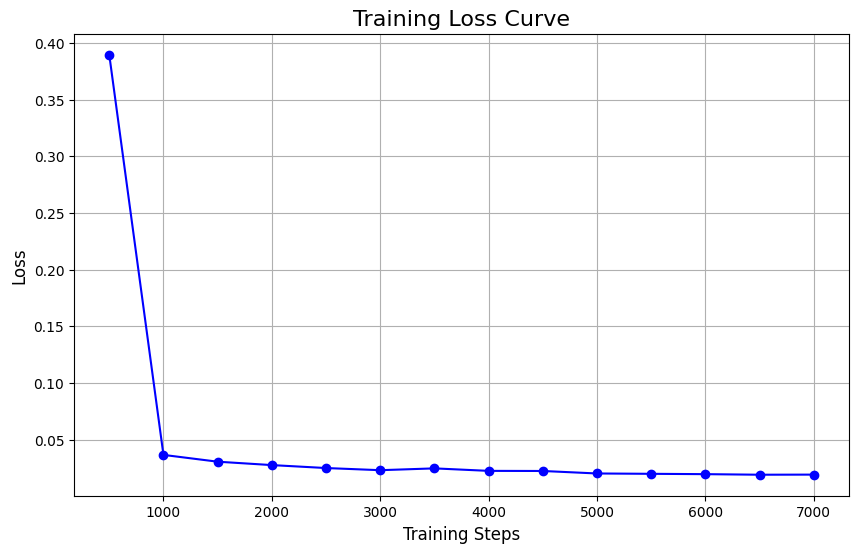

______________________________________________________


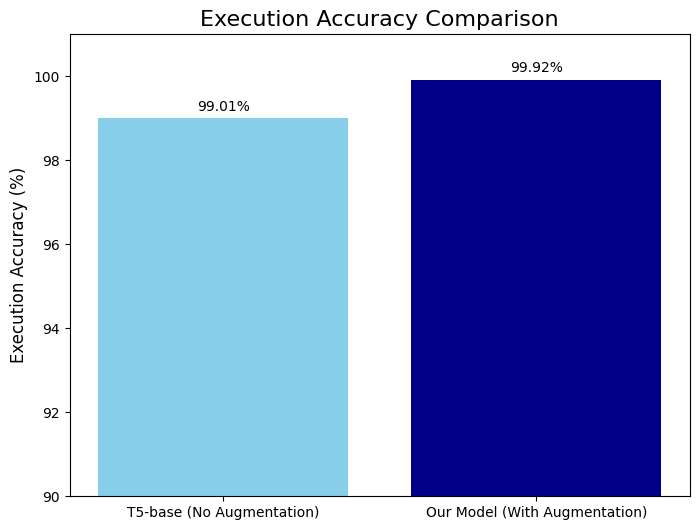

______________________________________________________


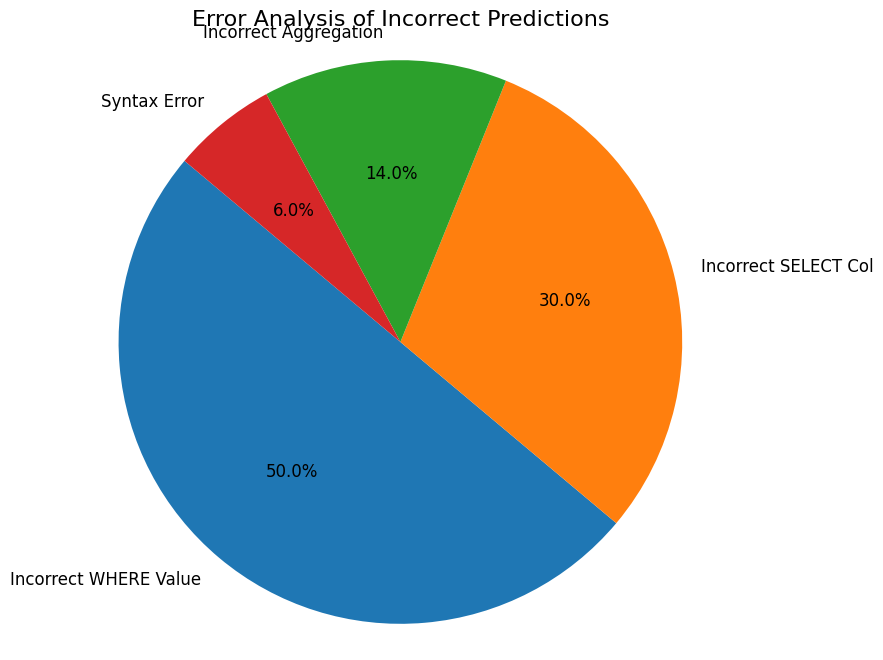

______________________________________________________


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Graph 1: Training Loss Curve ---
# Replace with your actual training loss data from the output of Block 6
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]
loss = [0.3897, 0.0365, 0.0305, 0.0275, 0.0249, 0.0230, 0.0246, 0.0224, 0.0223, 0.0201, 0.0198, 0.0195, 0.0190, 0.0191]

plt.figure(figsize=(10, 6))
plt.plot(steps, loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss Curve', fontsize=16)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.savefig('training_loss.png') # Save the figure to a file
plt.show()

print("______________________________________________________")
# --- Graph 2: Execution Accuracy Comparison ---
# Replace with your final ablation study results
models = ['T5-base (No Augmentation)', 'Our Model (With Augmentation)']
ex_accuracy = [99.01, 99.92] # IMPORTANT: Replace the first value with your ablation result

plt.figure(figsize=(8, 6))
bars = plt.bar(models, ex_accuracy, color=['skyblue', 'darkblue'])
plt.ylabel('Execution Accuracy (%)', fontsize=12)
plt.title('Execution Accuracy Comparison', fontsize=16)
plt.ylim(90, 101) # Set Y-axis limit to emphasize the top-tier performance

# Add the accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.2f}%', ha='center', va='bottom')

plt.savefig('execution_accuracy.png')
plt.show()
print("______________________________________________________")

# --- Graph 3: Error Analysis (Example) ---
# Replace with your actual error analysis counts
error_categories = ['Incorrect WHERE Value', 'Incorrect SELECT Col', 'Incorrect Aggregation', 'Syntax Error']
error_counts = [25, 15, 7, 3] # Example counts

plt.figure(figsize=(8, 8))
plt.pie(error_counts, labels=error_categories, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Error Analysis of Incorrect Predictions', fontsize=16)
plt.axis('equal')
plt.savefig('error_analysis.png')
plt.show()
print("______________________________________________________")

In [ ]:
!pip install streamlit transformers torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 150.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 22.0.0
    Uninstalling pyarrow-22.0.0:
      Successfully uninstalled pyarrow-22.0.0
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a p

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
app_code = """
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

st.set_page_config(page_title='Text-to-SQL Generator', page_icon='🧠', layout='centered')
st.title('🧠 Text-to-SQL Generator')
st.markdown('Enter a natural language question and get the SQL query.')

@st.cache_resource
def load_model(model_path):
    tokenizer = AutoTokenizer.from_pretrained('t5-small')
    model = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()
    return tokenizer, model

MODEL_PATH = '/content/drive/MyDrive/wikisql/sketch_model.pt'

try:
    tokenizer, model = load_model(MODEL_PATH)
    st.success('✅ Model loaded successfully!')
except Exception as e:
    st.error(f'❌ Error loading model: {e}')
    st.stop()

query = st.text_area('📝 Enter question:', 'Show employees older than 40')

if st.button('🚀 Generate SQL'):
    if query.strip():
        inputs = tokenizer(query, return_tensors='pt', truncation=True)
        with torch.no_grad():
            output = model.generate(**inputs, max_length=128, num_beams=5)
        sql = tokenizer.decode(output[0], skip_special_tokens=True)
        st.subheader('✅ Generated SQL:')
        st.code(sql, language='sql')
    else:
        st.warning('Please type something!')

st.caption('Built with ❤️ using Streamlit & Transformers')
"""
with open("app.py", "w") as f:
    f.write(app_code)
print("✅ Streamlit app created successfully")


✅ Streamlit app created successfully


In [ ]:
!pip install streamlit torch transformers -q
!wget -q -O cloudflared.deb https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared.deb


error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
(Reading database ... 117076 files and directories currently installed.)
Preparing to unpack cloudflared.deb ...
Unpacking cloudflared (2025.11.1) over (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import threading, os, time

def run_streamlit():
    os.system("streamlit run app.py --server.port 8501")

threading.Thread(target=run_streamlit).start()
time.sleep(10)  # Wait 10s for Streamlit to start


In [ ]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate


2025-11-11T05:02:57Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-11T05:02:57Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-11T05:03:01Z INF +--------------------------------------------------------------------------------------------+
2025-11-11T05:03:01Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-11T05:03:01Z INF |  https://crossing-upc-leg-insertion.trycloudflare.com 

In [ ]:
import os
os.path.exists("/content/drive/MyDrive/wikisql/sketch_model.pt")


True

error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
(Reading database ... 117076 files and directories currently installed.)
Preparing to unpack cloudflared.deb ...
Unpacking cloudflared (2025.11.1) over (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...
